In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_patterns(spread,N=2,p1=100,p2=100,option='separable',plot=False):
    # spread parameter is the standard deviation of the the patterns around each center of the gaussian distribution
    # generate targets
    
    z=np.ones((p1+p2))# targets
    z[p1:]=0 # t2=0 targets
    x=np.zeros((p1+p2,N))
    
    # generate inputs
    if option=='separable':
        # separable targets
        x[0:p1,0:N]=1+spread*np.random.randn(N*p1).reshape(p1,N)
        x[p1:p1+p2,0:N]=-1+spread*np.random.randn(N*p2).reshape(p2,N)
    elif option=='nonseparable':
        x[0:p1,0:N]=1+spread*np.random.randn(N*p1).reshape(p1,N)
        x[0:int(p1/2),0:N]=-x[0:int(p1/2),0:N]
        x[p1:p1+p2,0:N]=-1+spread*np.random.randn(N*p2).reshape(p2,N)
        x[int(p1+p2/2):(p1+p2),0]=-x[int(p1+p2/2):(p1+p2),0]; x[p1:int(p1+p2/2),1]=-x[p1:int(p1+p2/2),1]
    elif option=='weird':
        x[0:p1,0:N]=1+spread*np.random.randn(N*p1).reshape(p1,N)
        x[0:int(p1/2),0:N]=-x[0:int(p1/2),0:N]+1.5
        x[p1:p1+p2,0:N]=-1+spread*np.random.randn(N*p2).reshape(p2,N)
        x[int(p1+p2/2):(p1+p2),0]=-x[int(p1+p2/2):(p1+p2),0]; x[p1:int(p1+p2/2),1]=-x[p1:int(p1+p2/2),1]+1
        z=np.ones((p1+p2))# targets
        z[0:int(p1/2)]=0; z[p1:int(p1+p2/2)]=0

    # make a figure
    if plot == True:
        fig,ax=plt.subplots()
        plt.title('Linearly {} Patterns with Spread of {}'.format(option,spread))
        size=100
        # scatterplot
        ax.scatter(x[z==1,0],x[z==1,1],s=size,color='red',alpha=0.25,label='+1')
        ax.scatter(x[z==0,0],x[z==0,1],s=size,color='blue',alpha=0.25,label='0')
        ax.set_xlabel("x1"); ax.set_ylabel("x2")
        ax.legend(loc='lower right')
        ax.axis('equal')  
    return x,z

In [3]:
class NN(object):
    def __init__(self, *args, seed=3):
        nnshape = args
        #np.random.seed(seed)
        try:
            self.nnshape = np.array(nnshape,dtype=int)
        except:
            raise ValueError('Network shape must be a tuple of positive integers')
            
        self.trained = False
        self.depth   = len(nnshape)
        self.i_dim   = nnshape[0]
        self.o_dim   = nnshape[-1]
        self.weights = []
        self.training_epochs = 0
        #self.bias   = np.zeros(self.depth-1) #np.random.rand(self.depth-1) #np.zeros(self.depth-1)
        
        for i, L in enumerate(self.nnshape):
            if i==0:
                pass
            else:
                if L!=self.nnshape[-1]:
                    self.__dict__[f"weights_{i}"] = np.random.rand(self.nnshape[i]+1,self.nnshape[i-1]+1)
                    self.weights.append(self.__dict__[f"weights_{i}"])
                elif L==self.nnshape[-1]:
                    self.__dict__[f"weights_{i}"] = np.random.rand(self.nnshape[i],self.nnshape[i-1]+1)
                    self.weights.append(self.__dict__[f"weights_{i}"])
        
    def sig(self, ξ, d=False):
        h = 1/(1+np.exp(-ξ))
        return h#f*(1-f) if d else f
    
    
    def compute(self, input_data, **kwargs):
        try:
            to_layer = kwargs["layer"]
        except:
            to_layer = self.depth-1
            
        output = np.append(input_data,1)
        
        for i in range(to_layer):
            theta = self.weights[i]
            layer = theta@output
            #bias  = 0*np.ones_like(layer) #self.bias[i]
            output = self.sig(layer)
            
        return output
        
    def loss(self, input_data, target_data, gradient=False, sparse=False):
        
        W    = int(sparse)*(sum([(layer**2).sum() for layer in self.weights]) )
        y    = target_data
        yhat = self.compute(input_data)
        lyyh = y*np.log(yhat) + (1-y)*np.log(1-yhat)
        
        return np.abs(lyyh.mean())

    def train(self, train_data, target_data, epochs, learn_rate, error = 0.1):
        dp = 11
        prnt = np.round(np.linspace(0,epochs,dp))
        inc = 0
        for epoch in range(epochs):
            
            if epoch==epochs-1:
                train_error = 0
                for dat,targ in zip(train_data,target_data):
                    train_error += self.loss(dat, targ)
                error = str('%.3f'%(train_error))  ###
                loadbar = '['+int(inc)*'=='+ '=' + ']'
                string = f'Epoch={epoch+1}/{epochs}' + '\t\t' +loadbar + '\t' + f'training error={error}'
                print(string)
            elif epoch==int(prnt[inc]):
                train_error = 0
                for dat,targ in zip(train_data,target_data):
                    train_error += self.loss(dat, targ)
                error = str('%.3f'%(train_error))  ###
                loadbar = '['+int(inc)*'=='+(inc!=dp-1)*'>'+(dp-1-inc)*'--'+']'
                string = f'Epoch={epoch+1}/{epochs}' + '\t\t' +loadbar + '\t' + f'training error={error}'
                print(string)
                inc+=1
            gradient = [np.zeros_like(self.weights[i]) for i in range(len(self.weights))]
        
            
            for dat,targ in zip(train_data,target_data):
                
                activ_list = [self.compute(dat,layer=i) for i in range(self.depth)]
            
                delta_list = []
                
                for L in range(self.depth)[::-1]:
                    if L==self.depth-1:
                        delta = activ_list[-1] - targ
                        delta_list.append(delta)
                    else:
                        #print(delta_list[-1].shape,self.weights[L].shape,activ_list[L].shape)
                        
                        delta = activ_list[L]*(1-activ_list[L])*(delta_list[-1]@self.weights[L])
                        delta_list.append(delta)
                        gradient[L] = gradient[L] + np.outer(delta_list[-2],activ_list[L])
                        #print(gradient[L].shape, (np.outer(delta_list[-2],activ_list[L]).shape))

            ### update

            for i in range(len(self.weights)):
                #print(gradient[i].shape, self.weights[i].shape)
                self.weights[i] = self.weights[i] - learn_rate*gradient[i]/len(train_data)
            
            self.training_epochs +=1
            
        return print(f'Total training epochs = {self.training_epochs}')

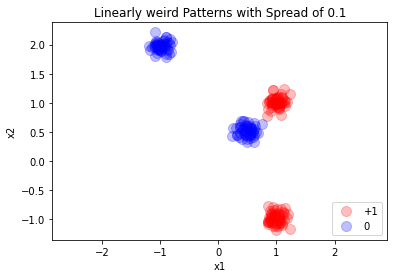

In [26]:
x, z = generate_patterns(0.1,N=2,p1=100,p2=100,option='weird',plot=True)

In [27]:
indx = np.random.choice(range(200),200,replace=False)
trn_indx = indx[0:100]
tst_indx = indx[100:]

x_train = x[trn_indx]
x_test  = x[tst_indx]

z_train = z[trn_indx]
z_test  = z[tst_indx]

In [28]:
mynet = NN(2,2,1)

In [47]:
mynet.train(x_train,z_train,10,0.1, error=0.01)

Epoch=1/10		[>--------------------]	training error=0.509
Epoch=2/10		[==>------------------]	training error=0.509
Epoch=3/10		[====>----------------]	training error=0.509
Epoch=4/10		[======>--------------]	training error=0.509
Epoch=5/10		[========>------------]	training error=0.509
Epoch=6/10		[==========>----------]	training error=0.509
Epoch=7/10		[============>--------]	training error=0.509
Epoch=8/10		[==============>------]	training error=0.509
Epoch=9/10		[================>----]	training error=0.509
Epoch=10/10		[===================]	training error=0.509
Total training epochs = 23010


In [46]:
for i in range(len(x_test)):
    pred = np.round(float(mynet.compute(x_test[i])),0)
    print(pred,  z_test[i])

1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
0.0 0.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.0 0.0
0.0 0.0
0.0 0.0
